In [15]:
import os
import re
import numpy as np
import pandas as pd
from collections import defaultdict

base_dir = "."  # or path to the folder containing the exp_baseline_cfg folders

# Config map for clarity in plots
config_map = {
    "cfg0": "FL",
    "cfg1": "FL + HE",
    "cfg2": "FL + HE + DP",
    "cfg3": "FL + DP"
}

server_metrics = ["avg_cpu", "peak_cpu", "avg_mem", "peak_mem"]

# Store round-wise metric data
config_round_data = {label: defaultdict(list) for label in config_map.values()}

# === Parse resource_usage.txt for each config/run ===
for folder in os.listdir(base_dir):
    match = re.match(r"exp_baseline_(cfg\d)_run\d+", folder)
    if match:
        cfg_key = match.group(1)
        config_label = config_map.get(cfg_key, None)
        if not config_label:
            continue
        try:
            log_dir = next(f for f in os.listdir(os.path.join(base_dir, folder)) if f.startswith("log_server_"))
            file_path = os.path.join(base_dir, folder, log_dir, "resource_usage.txt")

            with open(file_path, "r") as f:
                current_round = None
                round_data = {}

                for line in f:
                    round_match = re.match(r"Round (\d+):", line)
                    if round_match:
                        if current_round is not None:
                            config_round_data[config_label][current_round].append(round_data)
                        current_round = int(round_match.group(1))
                        round_data = {}
                    else:
                        metric_match = re.match(r"\s*(\w+):\s*([\d.]+)", line)
                        if metric_match:
                            key, val = metric_match.groups()
                            val = float(val)
                            if key in server_metrics:
                                round_data[key] = val

                if current_round is not None:
                    config_round_data[config_label][current_round].append(round_data)

        except Exception as e:
            print(f"❌ Error parsing {folder}: {e}")

# === Create summary tables ===
summary_tables = {}

for config, rounds_dict in config_round_data.items():
    round_numbers = sorted(rounds_dict.keys())
    summary_data = []

    for r in round_numbers:
        entry = {"Round": r}
        for metric in server_metrics:
            values = [run[metric] for run in rounds_dict[r] if metric in run]
            if values:
                entry[f"{metric} Mean"] = np.mean(values)
                entry[f"{metric} Std"] = np.std(values)
        summary_data.append(entry)

    summary_df = pd.DataFrame(summary_data).set_index("Round").round(2)
    summary_tables[config] = summary_df

# === Display summary tables ===
#for config_name, df in summary_tables.items():
 #   print(f"\n=== {config_name} Configuration ===")
  #  display(df)


In [16]:
# === Summarise server-side stats: average of each metric across all rounds ===
server_summary_rows = []

for config, df in summary_tables.items():
    row = {"Config": config}
    for metric in ["avg_cpu", "peak_cpu", "avg_mem", "peak_mem"]:
        col_name = f"{metric} Mean"
        if col_name in df.columns:
            row[metric] = round(df[col_name].mean(), 2)
        else:
            row[metric] = "-"
    server_summary_rows.append(row)

# Create DataFrame
server_summary_df = pd.DataFrame(server_summary_rows)
server_summary_df = server_summary_df.rename(columns={
    "avg_cpu": "Avg CPU (%)",
    "peak_cpu": "Peak CPU (%)",
    "avg_mem": "Avg Memory (MB)",
    "peak_mem": "Peak Memory (MB)"
}).set_index("Config")

display(server_summary_df)


,Avg CPU (%),Peak CPU (%),Avg Memory (MB),Peak Memory (MB)
Config,,,,
FL,1.35,24.97,1023.81,1031.04
FL + HE,2.40,29.13,1465.75,1575.56
FL + HE + DP,2.32,29.14,1474.02,1584.01
FL + DP,1.30,24.06,1023.29,1026.96


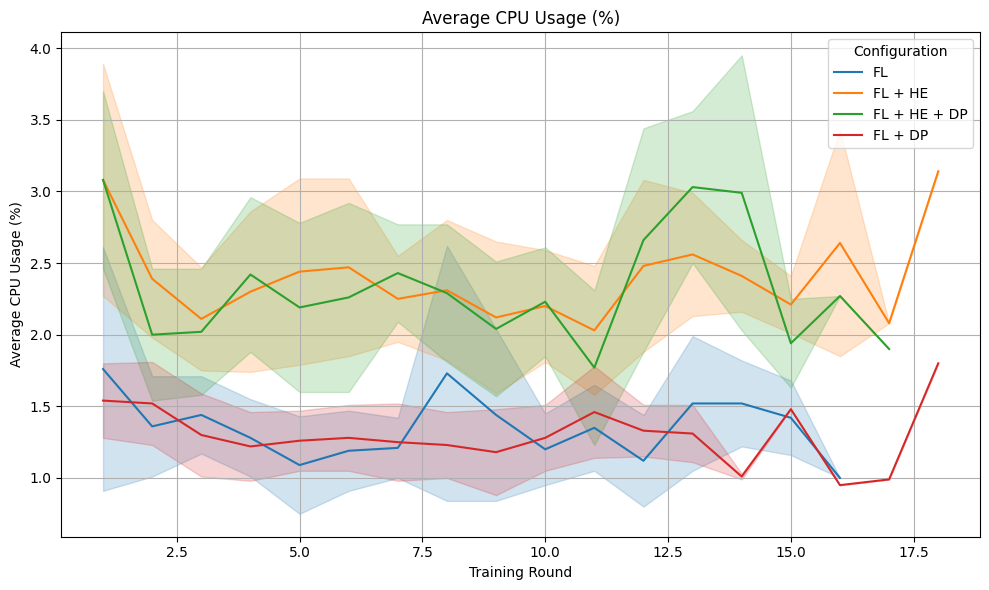

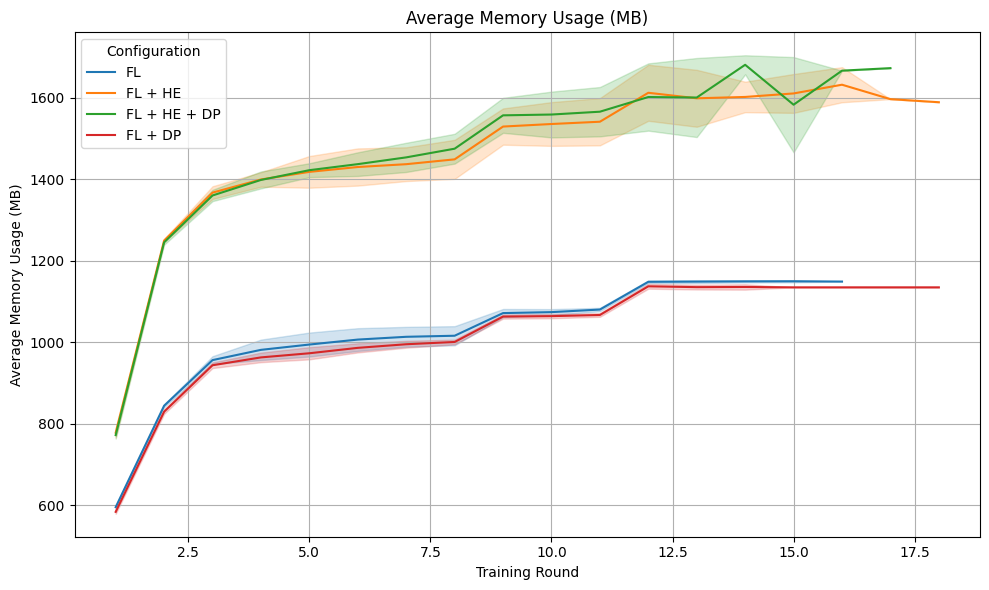

In [5]:
import matplotlib.pyplot as plt

# === Toggle: Choose how to display standard deviation ===
show_std = "shaded"  # Options: "shaded", "errorbar", "none"

# === Metric names and display labels ===
metric_labels = {
    "avg_cpu": "Average CPU Usage (%)",
    "avg_mem": "Average Memory Usage (MB)",
    # Uncomment if needed:
    #"peak_cpu": "Peak CPU Usage (%)",
    #"peak_mem": "Peak Memory Usage (MB)"
}

# Set plot colors
colors = plt.cm.tab10.colors
configs = list(summary_tables.keys())

# === Plot each metric ===
for metric_key, label in metric_labels.items():
    plt.figure(figsize=(10, 6))

    for idx, config in enumerate(configs):
        df = summary_tables[config]
        rounds = df.index.to_numpy()
        mean = df[f"{metric_key} Mean"].to_numpy()
        std = df[f"{metric_key} Std"].to_numpy()
        color = colors[idx]

        if show_std == "shaded":
            plt.plot(rounds, mean, label=config, color=color)
            plt.fill_between(rounds, mean - std, mean + std, color=color, alpha=0.2)
        elif show_std == "errorbar":
            plt.errorbar(rounds, mean, yerr=std, fmt='-o', capsize=4, color=color, label=config)
        else:  # show_std == "none"
            plt.plot(rounds, mean, label=config, color=color)

    plt.title(label)
    plt.xlabel("Training Round")
    plt.ylabel(label)
    plt.grid(True)
    plt.legend(title="Configuration")
    plt.tight_layout()
    plt.show()


In [12]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict

base_dir = "."  # current directory where experiments are stored

# Mapping from folder prefix to config label
config_map = {
    "cfg0": "FL",
    "cfg1": "FL + HE",
    "cfg2": "FL + HE + DP",
    "cfg3": "FL + DP"
}

# Metrics to extract
cpu_metrics = ["Avg CPU (%)", "Peak CPU (%)"]
mem_metrics = ["Avg Memory (MB)", "Peak Memory (MB)"]

# Create separate nested dictionaries for CPU and memory stats
cpu_data = {label: {metric: defaultdict(list) for metric in cpu_metrics} for label in config_map.values()}
mem_data = {label: {metric: defaultdict(list) for metric in mem_metrics} for label in config_map.values()}

# Walk through all experiment folders
for folder in os.listdir(base_dir):
    for cfg_prefix, label in config_map.items():
        if folder.startswith(f"exp_baseline_{cfg_prefix}_run"):
            try:
                # Find client metrics log path
                log_folder = [f for f in os.listdir(os.path.join(base_dir, folder)) if f.startswith("log_clients_")][0]
                csv_path = os.path.join(base_dir, folder, log_folder, "client_0", "metrics_log.csv")
                df = pd.read_csv(csv_path)

                for _, row in df.iterrows():
                    round_num = int(row["Round"])
                    for metric in cpu_metrics:
                        value = row.get(metric, None)
                        if pd.notnull(value):
                            cpu_data[label][metric][round_num].append(value)
                    for metric in mem_metrics:
                        value = row.get(metric, None)
                        if pd.notnull(value):
                            mem_data[label][metric][round_num].append(value)
            except Exception as e:
                print(f"❌ Failed to load from {folder}: {e}")


In [13]:
import pandas as pd
import numpy as np

# Target metrics with source dict and metric key
target_metrics = {
    "Avg CPU (%)": (cpu_data, "Avg CPU (%)"),
    "Peak CPU (%)": (cpu_data, "Peak CPU (%)"),
    "Avg Memory (MB)": (mem_data, "Avg Memory (MB)"),
    "Peak Memory (MB)": (mem_data, "Peak Memory (MB)")
}

# Final summary rows
summary_rows = []

for config in config_map.values():
    row = {"Config": config}
    for label, (source_dict, metric_key) in target_metrics.items():
        all_values = []
        metric_data = source_dict[config][metric_key]
        for round_values in metric_data.values():
            if isinstance(round_values, list):
                all_values.extend(round_values)
        numeric_values = [v for v in all_values if isinstance(v, (int, float, np.integer, np.floating))]
        row[label] = round(np.mean(numeric_values), 2) if numeric_values else "-"
    summary_rows.append(row)

# Create DataFrame
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.set_index("Config")
display(summary_df)


,Avg CPU (%),Peak CPU (%),Avg Memory (MB),Peak Memory (MB)
Config,,,,
FL,40.68,48.81,1184.73,1191.13
FL + HE,41.71,48.74,1425.00,1431.55
FL + HE + DP,41.76,48.88,1433.68,1439.99
FL + DP,41.08,48.36,1177.47,1183.77
